In [149]:
from castle.algorithms import PC
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import networkx as nx
import numpy as np
import pandas as pd

In [4]:
DATASET_PATH = './dataset/salaries.csv'

# Load dataset

In [90]:
def get_dataset(path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.drop(columns=['salary_currency', 'salary'])
    df = df.drop(df[df.work_year < 2023].index)
    df = df.drop(df[df.experience_level == 'EN'].index)
    df = df.drop(df[df.experience_level == 'EX'].index)
    df = df[df.employment_type == 'FT']
    df = df.drop(df[df.company_size == 'S'].index)
    df = df[df.company_location == 'US']
    df = df[df.employee_residence == 'US']
    accepted_job_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst', 'Machine Learning Engineer']
    df = df[df.job_title.isin(accepted_job_titles)]
    accepted_remote_ratio = [0, 100]
    df = df[df.remote_ratio.isin(accepted_remote_ratio)]
    df = df.drop(columns=['employee_residence', 'company_location','employment_type'])
    return df

dataset = get_dataset(DATASET_PATH)
dataset.head()

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size
12,2024,MI,Data Analyst,112300,0,M
13,2024,MI,Data Analyst,75100,0,M
22,2024,SE,Machine Learning Engineer,190000,0,M
23,2024,SE,Machine Learning Engineer,100000,0,M
24,2024,MI,Data Scientist,150650,0,M


In [91]:
dataset.job_title.value_counts()

Data Engineer                2435
Data Scientist               2397
Data Analyst                 1441
Machine Learning Engineer    1370
Name: job_title, dtype: int64

In [92]:
dataset.company_size.value_counts()

M    7536
L     107
Name: company_size, dtype: int64

In [94]:
dataset.experience_level.value_counts()

SE    5783
MI    1860
Name: experience_level, dtype: int64

In [95]:
dataset.remote_ratio.value_counts()

0      5372
100    2271
Name: remote_ratio, dtype: int64

In [100]:
pd.get_dummies(dataset.job_title)

,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer
12,1,0,0,0
13,1,0,0,0
22,0,0,0,1
23,0,0,0,1
24,0,0,1,0
...,...,...,...,...
14592,1,0,0,0
14593,0,0,0,1
14594,0,0,0,1
14595,0,0,1,0


In [102]:
dataset.head()

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size
12,2024,MI,Data Analyst,112300,0,M
13,2024,MI,Data Analyst,75100,0,M
22,2024,SE,Machine Learning Engineer,190000,0,M
23,2024,SE,Machine Learning Engineer,100000,0,M
24,2024,MI,Data Scientist,150650,0,M


In [157]:
# Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(df: pd.DataFrame, feature: list, drop_first = False) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature], drop_first=drop_first, prefix=feature)
    result = pd.concat([df, dummies], axis=1)
    result = result.drop([feature], axis=1)
    return result

dataset_encoded = dataset.copy()
features_to_encode = ['work_year', 'experience_level', 'job_title','company_size']
for f in features_to_encode:
    dataset_encoded = encode_and_bind(dataset_encoded, f, drop_first=True)

print(list(dataset_encoded.columns))

del f, features_to_encode

['salary_in_usd', 'remote_ratio', 'work_year_2024', 'experience_level_SE', 'job_title_Data Engineer', 'job_title_Data Scientist', 'job_title_Machine Learning Engineer', 'company_size_M']


# Build Model

In [158]:
# Define array
dataset_array = dataset_encoded.to_numpy()
dataset_array.shape

# Structure learning
pc = PC()
pc.learn(dataset_array)
pc.causal_matrix

Tensor([[0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])

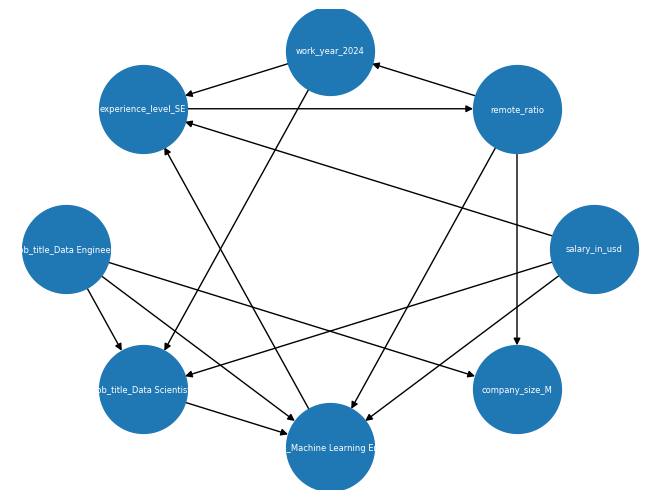

In [159]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(dataset_array.shape[1]), list(dataset_encoded.columns))}
learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)

# Plot the graph
nx.draw_circular(
    learned_graph, 
    with_labels=True,
    node_size=4000,
    font_size=6,
    font_color='white'
)